In [54]:
!pip install transformers langdetect
!pip install numpy==1.23.0
!pip install transformers
!pip install --no-cache-dir torchvision

import pandas as pd
from transformers import pipeline
from langdetect import detect
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import chi2_contingency
from scipy import stats

# Imports for the Sentiment Analysis
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

from scipy.stats import f_oneway

from scipy.special import softmax

In [ ]:
# read in the original dataset

df = pd.read_csv("da_content.csv",sep = ',', encoding = 'UTF-8', low_memory=False,error_bad_lines=False)

In [ ]:
# detect english language and delete all non-english entries

def detect_language(featured_content):
    try:
        lang = detect(featured_content)
        return lang == 'en'
    except:
        return False
    
#this code can be used alternatively 
#def filter_english_sentences(text):
#    english_sentences = []
#
#    for sentence in sentences:
#        if detect_language(sentence):
#            english_sentences.append(sentence)
#
#    return english_sentences  

In [ ]:
# filter for only paragraphs and apply language detection
df = df.loc[df["featured_type"] == 'paragraph']
df = df[df['featured_content'].apply(detect_language)]

In [ ]:
# load model for emotion detection

classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=None)

In [ ]:
# iterate through rows and save the score for each emotion in the according label

for index, row in df.iterrows():
    result = classifier(row['featured_content'])[0]

    for entry in result:
        emotion = entry['label']
        score = entry['score']
        df.at[index, emotion] = score

In [19]:
# get the emotion most present in each row and its score

df_all['MaxEmotionValue'] = df_all[['neutral', 'surprise', 'anger','joy', 'sadness', 'disgust', 'fear']].max(axis=1)
df_all['MaxEmotion'] = df_all[['neutral', 'surprise', 'anger','joy', 'sadness', 'disgust', 'fear']].idxmax(axis=1)

In [ ]:
# Sentiment Analysis
# PT version

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [ ]:
texts = df.featured_content
results = []

for idx, text in enumerate(texts):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        rank = i + 1
        label = config.id2label[ranking[i]]
        score = np.round(float(scores[ranking[i]]), 4)

        # Calculate the ID for every 3 results
        result_id = idx +1 // 3

        results.append({'result_id': result_id, 'rank': rank, 'label': label, 'score': score})

df_sentiment = pd.DataFrame(results)

# Pivot the DataFrame to get the desired format
df_sentiment = df_sentiment.pivot(index='result_id', columns='label', values='score').reset_index()

# Rename the columns for better readability
df_sentiment.columns.name = None
df_sentiment.columns = ['id','negativeSentiment', 'neutralSentiment', 'positiveSentiment']

df_sentiment['maxLabel'] = df_sentiment[['negativeSentiment', 'neutralSentiment', 'positiveSentiment']].idxmax(axis=1)
df['MaxSentimentValue'] = df.apply(lambda row: max(row['negativeSentiment'], row['neutralSentiment'], row['positiveSentiment']), axis=1).round(4)

df = pd.concat([df.reset_index(drop=True),df_sentiment.reset_index(drop= True)], axis=1)

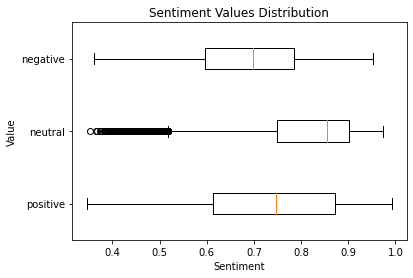

In [18]:
#boxplot of Sentimentdistribution

sentiment_order =  ['positive', 'neutral', 'negative']

sentiment_values = [df[df['maxLabel'] == sentiment]['MaxSentimentValue'] for sentiment in sentiment_order]

# Create the boxplot
plt.boxplot(sentiment_values, vert=False, labels=sentiment_order)

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Value')
plt.title('Sentiment Values Distribution')

# Display the plot
plt.show()

In [21]:
sentiment_max_emotion_counts = df.groupby('maxLabel')['MaxEmotion'].value_counts()

# Display the frequency count
print(sentiment_max_emotion_counts)

maxLabel  MaxEmotion
negative  neutral        10384
          disgust         6410
          sadness         3077
          fear            2623
          anger           1725
          surprise         271
          joy               74
neutral   neutral       191270
          disgust         9821
          joy             5090
          fear            3477
          sadness         3140
          anger           2178
          surprise        1031
positive  neutral        31837
          joy             4934
          surprise         666
          disgust          460
          fear             331
          sadness          295
          anger            204
Name: MaxEmotion, dtype: int64


In [19]:
# Emotion 

#df_box = df_all.describe()
# Sentiment description

df_b = df[['negativeSentiment', 'neutralSentiment', 'positiveSentiment']].describe()
print(df_b)
print("----------------------------------------------------")

# Emotion description

df_box = df[['joy', 'fear', 'anger', 'disgust', 'surprise', 'neutral', 'sadness']].describe()
print(df_box)
print("----------------------------------------------------")
#the position of the regular snippet that displayed the FS (they say its only between 1-10 from the first SERP)
print(df.featured_pos.value_counts())

print("----------------------------------------------------")
#normalized domain name
print(df.featured_main_domain.value_counts())

print("----------------------------------------------------")

#featured content mean length

print(df.featured_content_length.mean())

print("----------------------------------------------------")
# mean of the highest sentiment value to calculate the threshold featured snippets have in their sentiments

print(df.highest_value.mean())


print("----------------------------------------------------")



# Calculate the z-scores for the 'maxLabel' row
z_scores = np.abs(stats.zscore(df_all.highest_value))

# Define a threshold for outlier removal (e.g., z-score > 3)
threshold = 2

# Filter out data points where the z-score exceeds the threshold
filtered_data = df_all.highest_value[(z_scores <= threshold)]

# Calculate the mean of the filtered data
mean_without_outliers = filtered_data.mean()

print(mean_without_outliers)

       negativeSentiment  neutralSentiment  positiveSentiment
count      279298.000000     279298.000000      279298.000000
mean            0.110907          0.688202           0.200891
std             0.202968          0.258517           0.245296
min             0.001000          0.005700           0.003400
25%             0.009700          0.530700           0.045100
50%             0.022200          0.805500           0.088400
75%             0.077200          0.891500           0.245600
max             0.952800          0.973000           0.991700
----------------------------------------------------
                 joy           fear          anger        disgust  \
count  279298.000000  279298.000000  279298.000000  279298.000000   
mean        0.050918       0.034398       0.032326       0.080912   
std         0.136596       0.110672       0.084580       0.164499   
min         0.000221       0.000166       0.000508       0.000230   
25%         0.003611       0.002399       0.

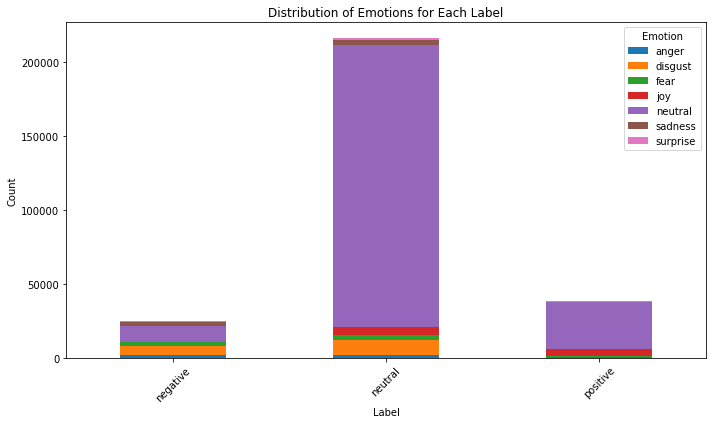

In [3]:
# Sentiment and Emotion distribution

# Group by 'label' and 'emotion' and count occurrences
grouped = df_all.groupby(['maxLabel', 'MaxEmotion']).size().reset_index(name='count')

# Pivot the data for plotting
pivot_df = grouped.pivot(index='maxLabel', columns='MaxEmotion', values='count')

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of Emotions for Each Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Emotion')
plt.tight_layout()

# Show the plot
plt.show()

In [4]:
# Investigating the relationship between emotions and sentiments


# Create a contingency table
contingency_table = pd.crosstab(df_all['MaxEmotion'], df_all['maxLabel'], margins=True)
print(contingency_table)
# Create a DataFrame
df_contin= pd.DataFrame(contingency_table)
# Perform chi-squared test
print("------------------------------")

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

threshold = 0.06
special = 0.0

# Interpret the p-value
if special < p < threshold:
    correlation_result = "correlated"
elif p == special:
    correlation_result = "correlated with p < 0.01"
else:
    correlation_result = "not correlated"

print(f"Emotions and Sentiments are {correlation_result} (p-value: {p})")

# Print the results
print("Chi-squared:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

maxLabel    negative  neutral  positive     All
MaxEmotion                                     
anger           1725     2178       204    4107
disgust         6410     9821       460   16691
fear            2623     3477       331    6431
joy               74     5090      4934   10098
neutral        10384   191270     31837  233491
sadness         3077     3140       295    6512
surprise         271     1031       666    1968
All            24564   216007     38727  279298
------------------------------
Emotions and Sentiments are correlated with p < 0.01 (p-value: 0.0)
Chi-squared: 61972.45360355351
P-value: 0.0
Degrees of freedom: 21
Expected frequencies: [[3.61206840e+02 3.17632331e+03 5.69469846e+02 4.10700000e+03]
 [1.46795797e+03 1.29086955e+04 2.31434653e+03 1.66910000e+04]
 [5.65600484e+02 4.97368766e+03 8.91711853e+02 6.43100000e+03]
 [8.88109732e+02 7.80971824e+03 1.40017202e+03 1.00980000e+04]
 [2.05353168e+04 1.80580206e+05 3.23754769e+04 2.33491000e+05]
 [5.72724359e+02 

In [24]:
# Filter the row to keep only values between 0.5 and 0.9
# This was done to remove all highest sentiment scores that were not above 50 percent and remove all that were over 90 percent as there were descriptoons of buzzwords that were not accuratly displaying the sentiemtn of featured snippets (outliers)
filtered_values = df.highest_value[(df.highest_value >= 0.5) & (df.highest_value <= 0.9)]

# Calculate the mean of the filtered values
mean_filtered = filtered_values.mean()

print(mean_filtered)


0.7559881630990269


In [ ]:
# Test to see whether when a featured snippet neutral is the subract from negative and positive close to zero is.

df['Subtract'] = df['positiveSentiment'] - merged_df['negativeSentiment']
df['Subtract'] = df['Subtract'].abs().round(4)